# Modeling Training and Deployment

In [61]:
import os
import re
import datetime as dt

import pandas as pd
import numpy as np
import math
from functions import *

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, confusion_matrix

from imblearn.over_sampling import SMOTE

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

## Load Data

In [2]:
df = pd.read_csv('data/archive_train.csv')
df.date_published = df.date_published.apply(lambda x: pd.to_datetime(x).date())
df.dropna(inplace=True)

df_most_shared = load_most_shared('data/most_popular_train')

In [3]:
popular_list = df_most_shared.uri.values
df['popular'] = [1 if x in popular_list else 0 for x in df['uri']]

In [4]:
df.head()

,uri,date_published,headline,keywords,snippet,word_count,popular
0,nyt://article/4e2abcbc-9563-56c0-bf18-c93ce4e7...,2021-12-01,let’s end the covid blame games,coronavirus omicron variantcoronavirus (2019-n...,"Finger pointing is pointless, divisive and dumb.",918,0
1,nyt://article/f7a5e7ef-e4cd-575c-a0e1-ff4d18d5...,2021-12-01,trump’s iran policy has become a disaster for ...,irannuclear weaponsembargoes and sanctionsunit...,Withdrawing from the Iran nuclear deal was a m...,1560,0
2,nyt://article/778af86c-b600-5aeb-be98-0a9a1aa1...,2021-12-01,this extinct eagle may have gulped guts like a...,eagles (birds)vultures (birds)condorsendangere...,Scientists suggest the largest eagle that ever...,913,0
3,nyt://article/fb7763c2-0f41-5c81-9ecf-17607ba5...,2021-12-01,republican recriminations point to a rocky pat...,republican partyhouse of representativesboeber...,Simmering tensions between the far-right flank...,1172,0
4,nyt://article/ba0afd37-0c00-5535-8868-21130e28...,2021-12-01,a times editor who attended oxford recalls a d...,school shootings and armed attacks,Three teenage students were killed on Tuesday ...,309,0


In [68]:
df.date_published[0]

datetime.date(2021, 12, 1)

## Exploratory Data Analysis  

In [6]:
print(df.info())
print()
print(df_most_shared.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4830 entries, 0 to 5380
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uri             4830 non-null   object
 1   date_published  4830 non-null   object
 2   headline        4830 non-null   object
 3   keywords        4830 non-null   object
 4   snippet         4830 non-null   object
 5   word_count      4830 non-null   int64 
 6   popular         4830 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 461.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 2022-01-13 to 2022-01-10
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uri             100 non-null    object
 1   date_published  100 non-null    object
dtypes: object(2)
memory usage: 2.3+ KB
None


,sum,percentage
popular,,
0,4752,0.98
1,78,0.02


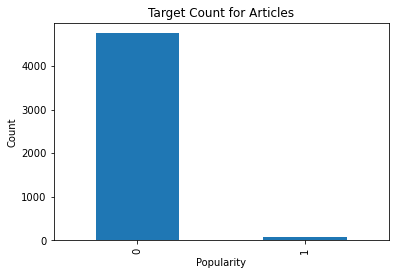

In [7]:
# value sentiments
popular_count = df.popular.value_counts().rename('sum')
popular_perc = df.popular.value_counts(normalize=True).round(2).rename('percentage')
popular_values = pd.concat([popular_count, popular_perc], axis=1)
popular_values['sum'].plot(kind='bar', title='Target Count for Articles', 
                                 xlabel='Popularity', ylabel='Count');
popular_values.index.name = 'popular'
popular_values

In [8]:
df_list_load = load_most_shared_eda('data/most_popular_train')
df_list = clean_most_shared_eda(df_list_load)

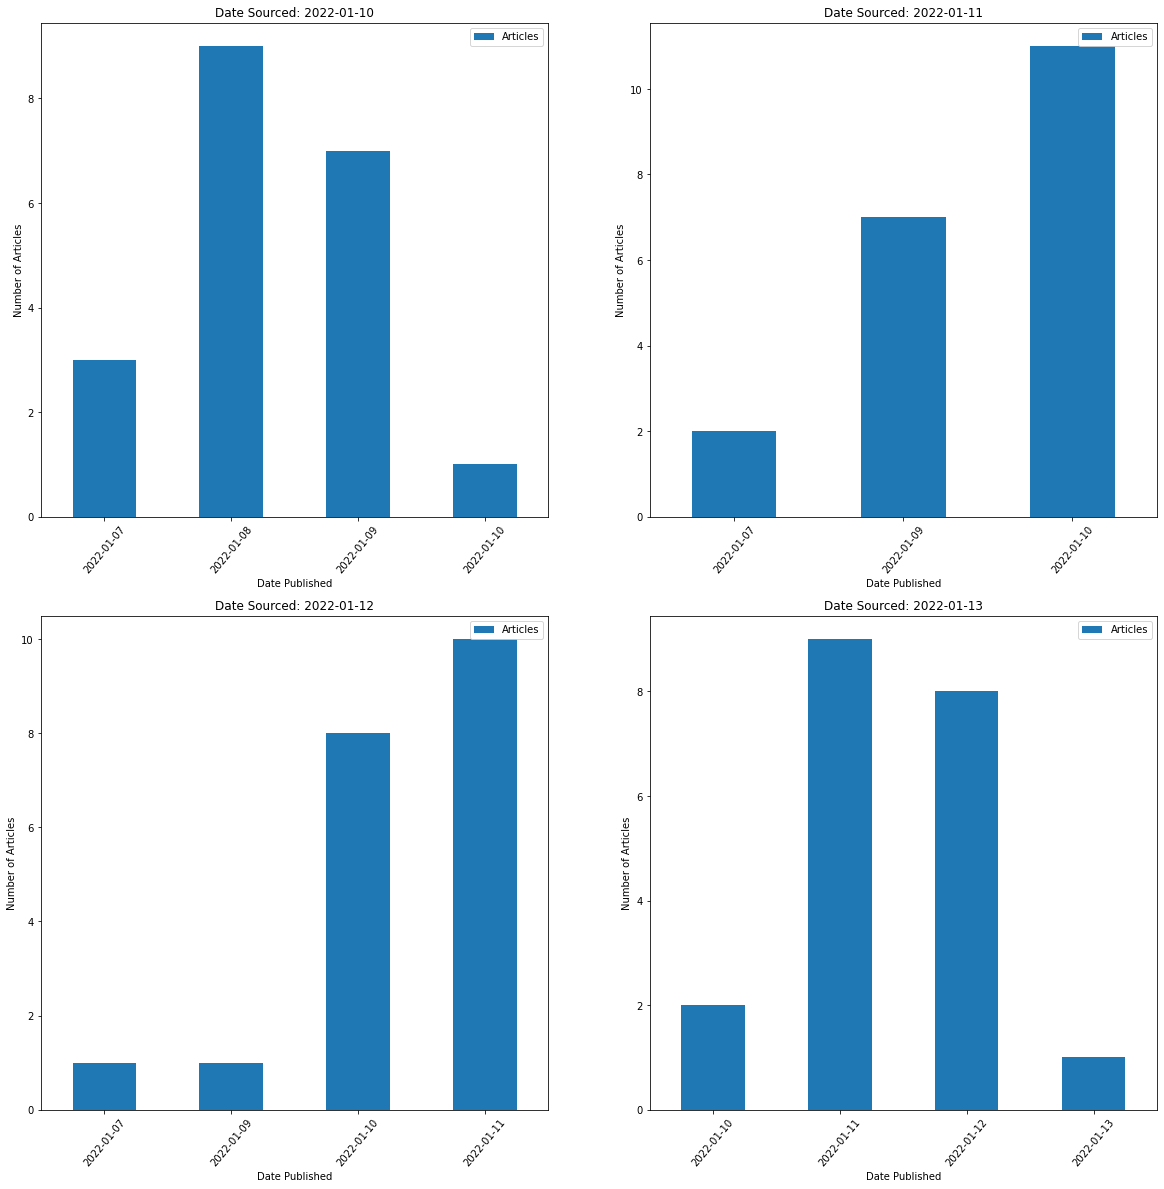

In [9]:
plot_most_shared(df_list)

## Train-Test Split

In [10]:
X = df.drop('popular', axis=1)
y = df.popular

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.40)

## Dummy classifier

In [12]:
dummy = DummyClassifier(random_state=0, strategy='stratified') 

#establishing random_state for reproducibility

dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

In [13]:
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))

Accuracy Score: 0.967391304347826


In [14]:
dummy_prob = dummy.predict_proba(X_test)
dummy_prob = [x[1] for x in dummy_prob if x[1] == 1]
len(dummy_prob)

40

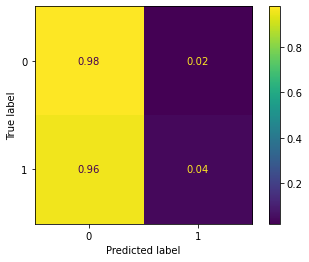

In [15]:
plot_confusion_matrix(estimator=dummy, X=X_test, y_true=y_test, normalize='true');

## Data Preprocessing 

#### Headline

##### TfidfVectorizer

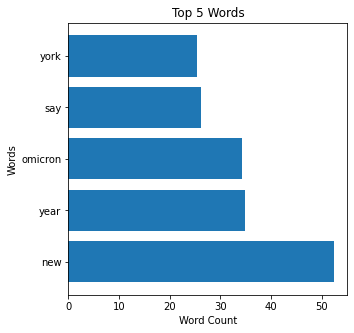

In [16]:
headline_tf, X_train_headline_tf, X_test_headline_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.headline, X_test.headline)

headline_tok_tf, X_train_headline_tok_tf, X_test_headline_tok_tf = tokenize_vector(headline_tf, 
                                                                                    X_train.headline, 
                                                                                    X_test.headline)


X_train_headline_tf_sm, y_train_headline_tf_sm = smote_data(X_train_headline_tok_tf, y_train, 
                                                  sampling_strategy='auto',random_state=0)
# used later
# vectorizor: headline_tok_tf
# data : X_train_headline_tf_sm, y_train_headline_tf_sm, X_test_headline_tok_tf

plot_top_words(headline_tok_tf, X_train_headline_tok_tf);

##### CountVectorizer

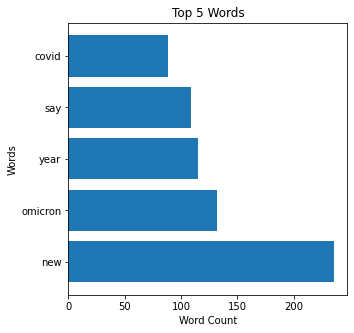

In [17]:
headline_cv, X_train_headline_cv, X_test_headline_cv = vectorize_feature(CountVectorizer, 
                                                                         X_train.headline, X_test.headline)

headline_tok_cv, X_train_headline_tok_cv, X_test_headline_tok_cv = tokenize_vector(headline_cv, 
                                                                                    X_train.headline, 
                                                                                    X_test.headline)

X_train_headline_cv_sm, y_train_headline_cv_sm = smote_data(X_train_headline_tok_cv, y_train, 
                                                  sampling_strategy='auto',random_state=0)
# used later
# vectorizor: headline_tok_cv
# data: X_train_headline_cv_sm, y_train_headline_cv_sm, X_test_headline_tok_cv

plot_top_words(headline_tok_cv, X_train_headline_tok_cv);

#### Keywords

##### TfidfVectorizer

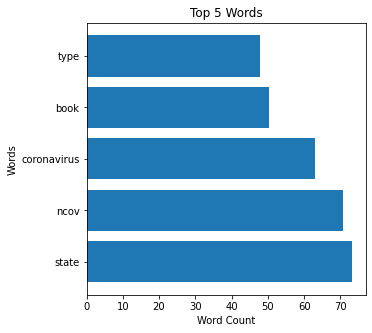

In [18]:
keywords_tf, X_train_keywords_tf, X_test_keywords_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.keywords, X_test.keywords)

keywords_tok_tf, X_train_keywords_tok_tf, X_test_keywords_tok_tf = tokenize_vector(keywords_tf, 
                                                                                    X_train.keywords, 
                                                                                    X_test.keywords)

X_train_keywords_tf_sm, y_train_keywords_tf_sm = smote_data(X_train_keywords_tok_tf, y_train, 
                                                  sampling_strategy='auto',random_state=0)
# used later
# vectorizor: keywords_tok_tf
# data: X_train_keywords_tf_sm, y_train_keywords_tf_sm, X_test_keywords_tok_tf

plot_top_words(keywords_tok_tf, X_train_keywords_tok_tf);

##### CountVectorizer

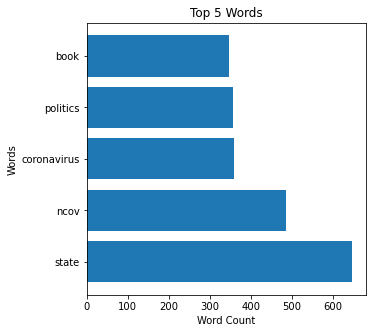

In [19]:
keywords_cv, X_train_keywords_cv, X_test_keywords_cv = vectorize_feature(CountVectorizer, 
                                                                         X_train.keywords, X_test.keywords)

keywords_tok_cv, X_train_keywords_tok_cv, X_test_keywords_tok_cv = tokenize_vector(keywords_cv, 
                                                                                    X_train.keywords, 
                                                                                    X_test.keywords)

X_train_keywords_cv_sm, y_train_keywords_cv_sm = smote_data(X_train_keywords_tok_cv, y_train, 
                                                  sampling_strategy='auto',random_state=0)
# used later
# vectorizor: keywords_tok_cv
# data: X_train_keywords_cv_sm, y_train_keywords_cv_sm, X_test_keywords_tok_cv

plot_top_words(keywords_tok_cv, X_train_keywords_tok_cv);

#### Snippet

##### TfidfVectorizer

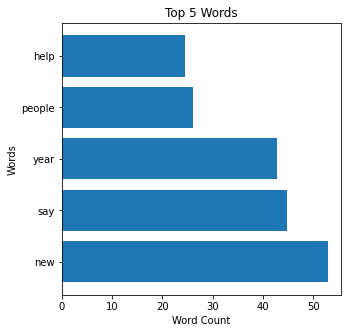

In [20]:
snippet_tf, X_train_snippet_tf, X_test_snippet_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.snippet, X_test.snippet)

snippet_tok_tf, X_train_snippet_tok_tf, X_test_snippet_tok_tf = tokenize_vector(snippet_tf, 
                                                                                    X_train.snippet, 
                                                                                    X_test.snippet)

X_train_snippet_tf_sm, y_train_snippet_tf_sm = smote_data(X_train_snippet_tok_tf, y_train, 
                                                  sampling_strategy='auto',random_state=0)
# used later
# vectorizor: snippet_tok_tf
# data: X_train_snippet_tf_sm, y_train_snippet_tf_sm, X_test_snippet_tok_tf

plot_top_words(snippet_tok_tf, X_train_snippet_tok_tf);

##### CountVectorizer

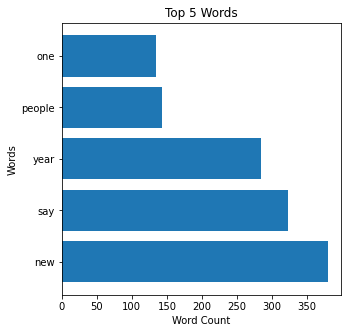

In [21]:
snippet_cv, X_train_snippet_cv, X_test_snippet_cv = vectorize_feature(CountVectorizer, 
                                                                         X_train.snippet, X_test.snippet)

snippet_tok_cv, X_train_snippet_tok_cv, X_test_snippet_tok_cv = tokenize_vector(snippet_cv, 
                                                                                 X_train.snippet, 
                                                                                 X_test.snippet)

X_train_snippet_cv_sm, y_train_snippet_cv_sm = smote_data(X_train_snippet_tok_cv, y_train, 
                                                          sampling_strategy='auto', random_state=0)
# used later
# vectorizor: snippet_tok_cv
# data: X_train_snippet_cv_sm, y_train_snippet_cv_sm, X_test_snippet_tok_cv

plot_top_words(snippet_tok_cv, X_train_snippet_tok_cv);

#### Word Count

In [22]:
X_train_word_count_sm, y_train_word_count_sm = smote_data(X_train.word_count.values.reshape(-1, 1), 
                                                          y_train, sampling_strategy='auto',
                                                          random_state=0)

## Model Training - Text

In [23]:
def random_forrest_proba(X_train, y_train, X_test, y_test):
    
    forrest = RandomForestClassifier()
    grid = {'n_estimators': [50,75,100]}
    
    gs = GridSearchCV(estimator=forrest, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    class_probability = gs.predict_proba(X_test)
    target_probability = [x[1] for x in class_probability]
    
    score = gs.score(X_test, y_test)
    print(f'mean accuracy: {score}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plt.title('ROC Curve')
    plot_roc_curve(gs, X_train, y_train, name='Train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='Test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test)
    
    return gs, target_probability

In [24]:
def random_forrest_class(X_train, y_train, X_test, y_test):
    
    forrest = RandomForestClassifier()
    grid = {'n_estimators': [50,75,100]}
    
    gs = GridSearchCV(estimator=forrest, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    class_prediction = gs.predict(X_test)
    
    score = gs.score(X_test, y_test)
    print(f'mean accuracy: {score}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plt.title('ROC Curve')
    plot_roc_curve(gs, X_train, y_train, name='Train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='Test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test)
    
    return gs, class_prediction

### Headline

##### Predict Probability after TfidfVectorizer

mean accuracy: 0.9865424430641822
number of probabilities: 1932



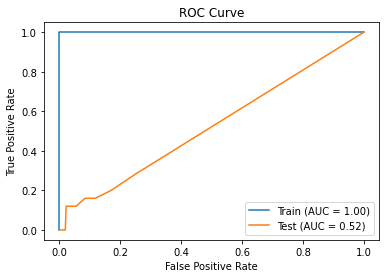

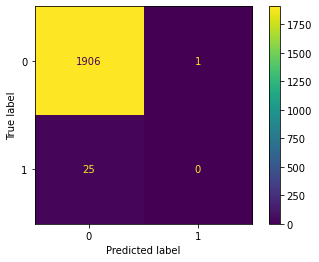

In [25]:
headline_proba_rf, headline_proba = random_forrest_proba(X_train_headline_tf_sm, y_train_headline_tf_sm, 
                                                         X_test_headline_tok_tf, y_test)
print(f'number of probabilities: {len(headline_proba)}')
print()

##### Predict Class after CountVectorizer

mean accuracy: 0.7210144927536232
number of class predictions: 1932



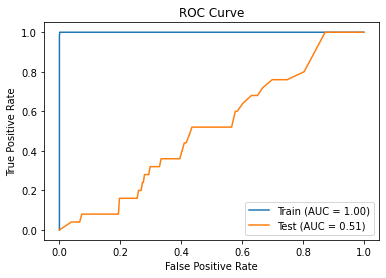

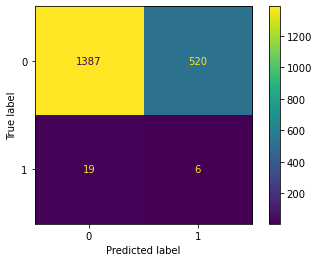

In [26]:
headline_class_rf, headline_class = random_forrest_class(X_train_headline_cv_sm, y_train_headline_cv_sm, 
                                                         X_test_headline_tok_cv, y_test)
print(f'number of class predictions: {len(headline_class)}')
print()

### Keywords

##### Predict Probability after TfidfVectorizer

mean accuracy: 0.9870600414078675
number of probabilities: 1932



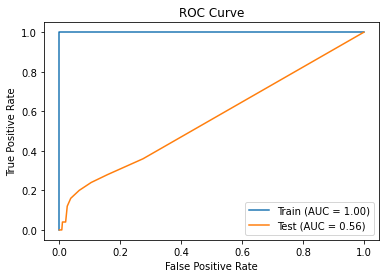

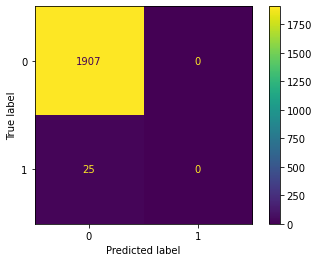

In [27]:
keywords_proba_rf, keywords_proba = random_forrest_proba(X_train_keywords_tf_sm, y_train_keywords_tf_sm, 
                                                         X_test_keywords_tok_tf, y_test)
print(f'number of probabilities: {len(keywords_proba)}')
print()

##### Predict Class after CountVectorizer

mean accuracy: 0.8002070393374742
number of class predictions: 1932



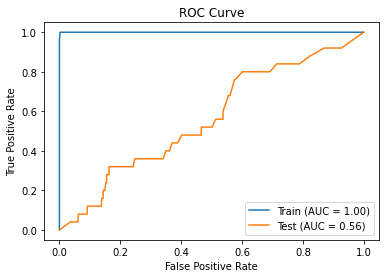

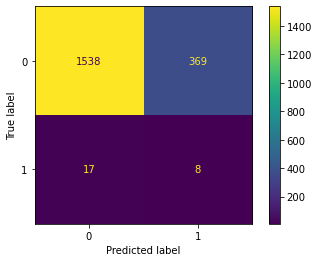

In [28]:
keywords_class_rf, keywords_class = random_forrest_class(X_train_keywords_cv_sm, y_train_keywords_cv_sm, 
                                                         X_test_keywords_tok_cv, y_test)
print(f'number of class predictions: {len(keywords_class)}')
print()

### Snippet 

##### Predict Probability after TfidfVectorizer

mean accuracy: 0.9870600414078675
number of probabilities: 1932



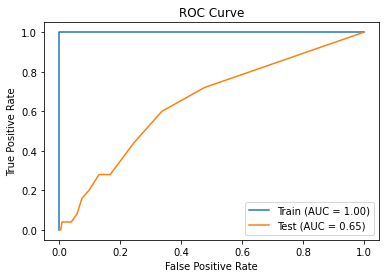

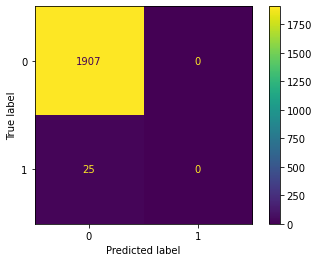

In [29]:
snippet_proba_rf, snippet_proba = random_forrest_proba(X_train_snippet_tf_sm, y_train_snippet_tf_sm, 
                                                       X_test_snippet_tok_tf, y_test)
print(f'number of probabilities: {len(snippet_proba)}')
print()

##### Predict Class after CountVectorizer

mean accuracy: 0.8162525879917184
number of class predictions: 1932



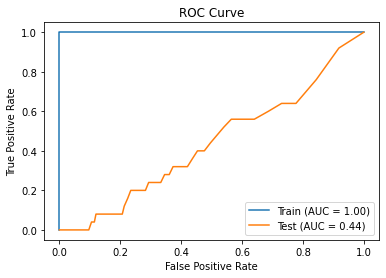

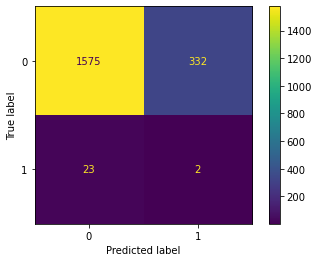

In [30]:
snippet_class_rf, snippet_class = random_forrest_class(X_train_snippet_cv_sm, y_train_snippet_cv_sm, 
                                                       X_test_snippet_tok_cv, y_test)
print(f'number of class predictions: {len(snippet_class)}')
print()

## Model Training - Numeric

##### Word Count

In [31]:
def log_regression_word_count(X_train, y_train, X_test, y_test):
        
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    
    # precting class labels
    class_prediction = clf.predict(X_test.values.reshape(-1, 1))
    
    # predicitng probaility of class
    probabilities = clf.predict_proba(X_test.values.reshape(-1, 1))
    probabilities = [x[1] for x in probabilities]
    
    
    score = clf.score(X_test.values.reshape(-1, 1), y_test)
    print(f'mean accuracy: {score}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plt.title('ROC Curve')
    plot_roc_curve(clf, X_train, y_train, name='Train', ax=ax)
    plot_roc_curve(clf, X_test.values.reshape(-1, 1), y_test, name='Test', ax=ax);
    
    # Plot Confusion Matrix
    plot_confusion_matrix(clf, X_test.values.reshape(-1, 1), y_test)
    
    return clf, probabilities, class_prediction

mean accuracy: 0.5657349896480331
number of probabilities: 1932
number of class predictions: 1932



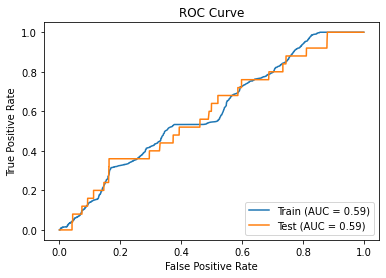

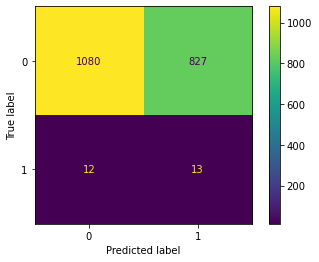

In [32]:
word_count_log_reg, word_count_proba, word_count_class = log_regression_word_count(X_train_word_count_sm, 
                                                                                    y_train_word_count_sm, 
                                                                                    X_test.word_count, y_test)
print(f'number of probabilities: {len(word_count_proba)}')
print(f'number of class predictions: {len(word_count_class)}')
print()

## Cumulative Model 

### Cleaning Proability Data

In [33]:
df_predict_proba = pd.DataFrame({'headline_prob': headline_proba, 
                           'keywords_prob': keywords_proba, 
                           'snippet_prob': snippet_proba,
                           'word_count_prob': word_count_proba})

In [34]:
df_predict_proba.head()

,headline_prob,keywords_prob,snippet_prob,word_count_prob
0,0.00,0.00,0.00,0.525553
1,0.20,0.00,0.00,0.446034
2,0.00,0.00,0.03,0.419693
3,0.20,0.04,0.01,0.546700
4,0.02,0.00,0.00,0.529070


In [35]:
df_predict_proba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1932 entries, 0 to 1931
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   headline_prob    1932 non-null   float64
 1   keywords_prob    1932 non-null   float64
 2   snippet_prob     1932 non-null   float64
 3   word_count_prob  1932 non-null   float64
dtypes: float64(4)
memory usage: 60.5 KB


### Cleaning Class Labeled Data 

In [36]:
df_predict_class = pd.DataFrame({'headline_prob': headline_class, 
                           'keywords_prob': keywords_class, 
                           'snippet_prob': snippet_class,
                           'word_count_prob': word_count_class})

In [37]:
df_predict_class.head()

,headline_prob,keywords_prob,snippet_prob,word_count_prob
0,0,0,0,1
1,0,1,0,0
2,0,0,0,0
3,1,0,0,1
4,0,0,0,1


In [38]:
df_predict_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1932 entries, 0 to 1931
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   headline_prob    1932 non-null   int64
 1   keywords_prob    1932 non-null   int64
 2   snippet_prob     1932 non-null   int64
 3   word_count_prob  1932 non-null   int64
dtypes: int64(4)
memory usage: 60.5 KB


### Modeling

In [39]:
y_test.value_counts(normalize=True)

0    0.98706
1    0.01294
Name: popular, dtype: float64

#### Probability 

In [40]:
clf_proba = LogisticRegression()

In [41]:
clf_proba.fit(df_predict_proba, y_test)

LogisticRegression()

### Class

In [42]:
clf_class = LogisticRegression()

In [43]:
clf_class.fit(df_predict_class, y_test)

LogisticRegression()

## Model Deployment

In [ ]:
df_archive_deploy = pd.read_csv('data/archive_deploy.csv')
df_archive_deploy.date_published = df_archive_deploy.date_published.apply(lambda x: pd.to_datetime(x).date())

df_most_shared_deploy = load_most_shared('data/most_popular_deploy')

In [ ]:
def filter_predction_dfs(day_of_predict, delta=3, df_archive, df_shared):
    
    day_of_predict = pd.to_datetime(day_of_predict).date()
    time_delta = dt.timedelta(days=delta)
    
    cutoff_day = day_of_predict - time_delta
    
    df_deploy = df_archive[(df_archive.date_published >= cutoff_day) & 
                             (df_archive.date_published <= day_of_predict)]
    article_ids = df_deploy['uri']
    df_feature_deploy = df_deploy[['headline','keywords','snippet','word_count']]
    
    
    df_top_20 = df_shared[df_shared.date_sourced == day_of_predict]
    
    return article_ids, df_feature_deploy, df_top_20

In [ ]:
prediction_day = 'string_date'

In [ ]:
deployed_article_ids, df_feature_deploy, df_top_20 = filter_predction_dfs(prediction_day, delta=3, 
                                                                  df_archive_deploy, df_most_shared_deploy)

In [85]:
def predict_with_probabilities():
    
    headline = df.headline
    keywords = df.keywords
    snippet = df.snippet
    word_count = df.word_count
    
    headline_tf_vec.transform()
    headline_tf_vec_tok.transform()
    headline_proba_rf.predict_proba()
    
    keywords_tf_vec.transform
    keywords_tf_vec_tok.transform
    keywords_proba_rf.predict_proba
    
    snippet_tf_vec.transform
    snippet_tf_vec_tok.transform
    snippet_proba_rf.predict_proba
    
    word_count_log_reg.predict_proba

    

In [86]:
def predict_with_class_labels(df):
    
    headline = df.headline
    keywords = df.keywords
    snippet = df.snippet
    word_count = df.word_count
    
    headline_cv_vec.transform
    headline_cv_vec_tok.transform
    headline_class_rf.predict
    
    keywords_cv_vec.transform
    keywords_cv_vec_tok.transform
    keywords_class_rf.predict
    
    snippet_cv_vec.transform
    snippet_cv_vec_tok.transform
    snippet_class_rf.predict
    
    word_count_log_reg.predict
    
    

In [87]:
headline_proba_pipe = Pipeline([('headline_tok_tf', headline_tok_tf), 
                                ('headline_proba_rf',headline_proba_rf)])

In [88]:
keywords_proba_pipe = Pipeline([('keywords_tok_tf', keywords_tok_tf), 
                                ('keywords_proba_rf', keywords_proba_rf)])

In [89]:
snippet_proba_pipe = Pipeline([('snippet_tok_tf', snippet_tok_tf), 
                               ('snippet_proba_rf', snippet_proba_rf)])

In [90]:
def proba_nlp_pipeline(features):
    headline_probs = headline_proba_pipe.predict_proba(features.headline)
    keywords_probs  = keywords_proba_pipe.predict_proba(features.keywords)
    snippet_probs  = snippet_proba_pipe.predict_proba(features.snippet)
    word_count_probs = word_count_log_reg.predict_proba(features.word_count)
    
    df = pd.DataFrame({'headline_probabilty': headline_probs, 
                       'keywords_probabilty': keywords_probs,
                       'snippet_probabilty': snippet_probs,
                       'word_count_probabilty': word_count_probs})
    return df

In [91]:
headline_class_pipe = Pipeline([('headline_tok_cv', headline_tok_cv), 
                                ('headline_class_rf', headline_class_rf)])

In [92]:
keywords_class_pipe = Pipeline([('keywords_tok_cv', keywords_tok_cv), 
                                ('keywords_class_rf', keywords_class_rf)])

In [93]:
snippet_class_pipe = Pipeline([('snippet_tok_cv', snippet_tok_cv), 
                               ('snippet_class_rf', snippet_class_rf)])

In [94]:
def class_nlp_pipeline(features):
    headline_probs = headline_class_pipe.predict_proba(features.headline)
    keywords_probs  = keywords_class_pipe.predict_proba(features.keywords)
    snippet_probs  = snippet_class_pipe.predict_proba(features.snippet)
    word_count_probs = word_count_log_reg.predict_proba(features.word_count)
    
    df = pd.DataFrame({'headline_probabilty': headline_probs, 
                       'keywords_probabilty': keywords_probs, 
                       'snippet_probabilty': snippet_probs, 
                       'word_count_probabilty': word_count_probs})
    return df

In [58]:
# proba_for_pred = proba_nlp_pipeline(df_feature_deploy)

In [59]:
# class_for_pred = class_nlp_pipeline(df_feature_deploy)

In [60]:
# predictions_from_proba = clf_proba.predict_proba(proba_for_pred)

In [61]:
# predictions_from_class = clf_class.predict_proba(class_for_pred)

In [ ]:
# top_20_from_proba = pd.DataFrame([deployed_article_ids, predictions_from_proba])

In [ ]:
# top_20_from_class = pd.DataFrame([deployed_article_ids, predictions_from_class])